[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Segment Videos with Segment Anything 3 (SAM3)

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-videos-with-segment-anything-3.ipynb) [![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/sam3/) [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/sam3)

SAM 3 (Segment Anything Model 3) extends the SAM series by moving from segmenting individual objects to understanding and segmenting all instances of a concept in images and videos. It introduces Promptable Concept Segmentation (PCS), where users specify a concept through short noun phrases like “striped cat” or by providing visual exemplars. The model detects, segments, and tracks every matching object, preserving identities across frames.


## Environment setup

### Configure your API keys

To pull Segment Anything 3 weights, you need a HuggingFace Access Token with approved access to the SAM 3 checkpoints.

- Request access to the SAM 3 checkpoints on the official Hugging Face [repo](https://github.com/facebookresearch/sam3).
- Open your HuggingFace Settings page. Click Access Tokens then New Token to generate a new token.
- In Colab, go to the left pane and click on Secrets (🔑). Store your HuggingFace Access Token under the name `HF_TOKEN`.



In [7]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("Hugging_Face")

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sun Nov 23 07:10:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import torch
import torchvision

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True


### Install SAM 3 and extra dependencies

In [4]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e ".[notebooks]"
%cd /content

Cloning into 'sam3'...
remote: Enumerating objects: 551, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 551 (delta 41), reused 35 (delta 35), pack-reused 419 (from 2)
Receiving objects: 100% (551/551), 58.93 MiB | 13.28 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 k

/content


In [1]:
!pip install -q supervision jupyter_bbox_widget

In [2]:
!pip uninstall -y cc_torch; TORCH_CUDA_ARCH_LIST="8.0 9.0"; pip install git+https://github.com/ronghanghu/cc_torch
!pip uninstall -y torch_generic_nms; TORCH_CUDA_ARCH_LIST="8.0 9.0"; pip install git+https://github.com/ronghanghu/torch_generic_nms

  Cloning https://github.com/ronghanghu/cc_torch to /tmp/pip-req-build-4dhpdp3s
  Running command git clone --filter=blob:none --quiet https://github.com/ronghanghu/cc_torch /tmp/pip-req-build-4dhpdp3s
  Resolved https://github.com/ronghanghu/cc_torch to commit 446e9360ed10d3c8d03925ccb5f220ccb62009de
  Preparing metadata (setup.py) ... done
  Created wheel for cc_torch: filename=cc_torch-0.2-cp312-cp312-linux_x86_64.whl size=322910 sha256=174ff47cc65fc44259186a9b7d1368e4827386393d79039a3fc1894a5c07c623
  Stored in directory: /tmp/pip-ephem-wheel-cache-jk9sdfgu/wheels/ec/00/d2/dd6e3f726591979dbc35c61d4feb785f48529310b422937236
Successfully built cc_torch
  Cloning https://github.com/ronghanghu/torch_generic_nms to /tmp/pip-req-build-znnqz9nq
  Running command git clone --filter=blob:none --quiet https://github.com/ronghanghu/torch_generic_nms /tmp/pip-req-build-znnqz9nq
  Resolved https://github.com/ronghanghu/torch_generic_nms to commit fcf02b41ea9b37988b244ef80583af17baa4a7f0
  Prepa

### Download example data

Downloads example videos. You can use these or replace them with your own videos.

In [ ]:
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/jets-1280x720-1.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/jets-1280x720-2.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/jets-1280x720-3.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/go-karts-1280x720-3.mp4

<font color="red">⚠️ Restart session.</font>

## Imports

In [3]:
import cv2
import torch

import numpy as np
import supervision as sv

from pathlib import Path
from PIL import Image
from typing import Optional
from IPython.display import Video

from sam3.model_builder import build_sam3_video_predictor

In [4]:
HOME = Path.cwd()
print("HOME:", HOME)

HOME: /content


## Promptable Concept Segmentation (PCS)

### Load SAM3 model

In [5]:
# use all available GPUs on the machine
# DEVICES = range(torch.cuda.device_count())

# # use only a single GPU
DEVICES = [torch.cuda.current_device()]

In [8]:
predictor = build_sam3_video_predictor(gpus_to_use=DEVICES)

INFO 2025-11-23 07:15:03,080 2470 sam3_video_predictor.py: 299: using the following GPU IDs: [0]
INFO 2025-11-23 07:15:03,082 2470 sam3_video_predictor.py: 315: 


	*** START loading model on all ranks ***


INFO 2025-11-23 07:15:03,083 2470 sam3_video_predictor.py: 317: loading model on rank=0 with world_size=1 -- this could take a while ...
INFO 2025-11-23 07:15:13,750 2470 sam3_video_base.py: 124: setting max_num_objects=10000 and num_obj_for_compile=16


config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

INFO 2025-11-23 07:17:36,147 2470 sam3_video_predictor.py: 319: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2025-11-23 07:17:36,163 2470 sam3_video_predictor.py: 330: 


	*** DONE loading model on all ranks ***




### Process the video

SAM 3 assumee that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`. Let's start by downloading a sample video, splitting it into frames, and saving them to disk. Feel free to replace `SOURCE_VIDEO` with the path to your video file.

In [9]:
SOURCE_VIDEO = HOME / "football_front_view.mp4"
SOURCE_FRAMES = HOME / SOURCE_VIDEO.stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

!ffmpeg -i {SOURCE_VIDEO} -q:v 2 -start_number 0 {SOURCE_FRAMES}/'%05d.jpg'

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [10]:
def load_frame(directory: str, index: int):
    """
    Loads a frame with a specific index from a directory where frames are named
    using the pattern '%05d.jpg' (e.g., 00000.jpg, 00001.jpg, 00002.jpg).

    Args:
        directory (str): Path to the directory containing image frames.
        index (int): Frame index (0-based).

    Returns:
        numpy.ndarray: Loaded frame in BGR format.

    Raises:
        FileNotFoundError: If the frame does not exist or cannot be read.
    """
    directory_path = Path(directory)
    frame_path = directory_path / f"{index:05d}.jpg"

    if not frame_path.exists():
        raise FileNotFoundError(f"Frame not found: {frame_path}")

    frame = cv2.imread(str(frame_path))
    if frame is None:
        raise FileNotFoundError(f"Failed to load frame: {frame_path}")

    return frame

### Opening video inference session


SAM 3 requires stateful inference for interactive video segmentation, so we need to initialize an inference session on this video. During initialization, it loads all the JPEG frames in the video directory and stores their features in the session state.

In [11]:
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=SOURCE_VIDEO.as_posix(),
    )
)
session_id = response["session_id"]

frame loading (OpenCV) [rank=0]: 100%|██████████| 290/290 [00:05<00:00, 49.79it/s]


In [12]:
_ = predictor.handle_request(
    request=dict(
        type="reset_session",
        session_id=session_id,
    )
)

### Adding a text prompt

Here we use the text prompt "person" to detect all people in the video. SAM 3 will automatically identify multiple person instances and assign each a unique object ID.

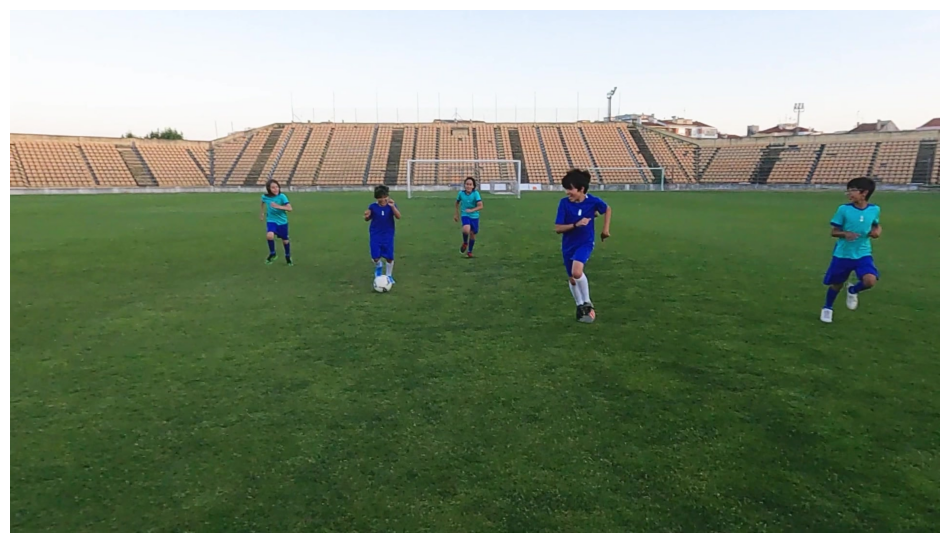

In [13]:
frame_idx = 0
frame = load_frame(SOURCE_FRAMES, frame_idx)

sv.plot_image(frame)

In [14]:
text = "person"
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=frame_idx,
        text=text,
    )
)
result = response["outputs"]

### Visualize results

In [15]:
def from_sam(result: dict) -> sv.Detections:
    return sv.Detections(
        xyxy=sv.mask_to_xyxy(result["out_binary_masks"]),
        mask=result["out_binary_masks"],
        confidence=result["out_probs"],
        tracker_id=result["out_obj_ids"],
    )

In [16]:
COLOR = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

def annotate(image: np.ndarray, detections: sv.Detections, text = None) -> np.ndarray:
    h, w, _ = image.shape
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=(w, h))

    mask_annotator = sv.MaskAnnotator(
        color=COLOR,
        color_lookup=sv.ColorLookup.TRACK,
        opacity=0.6
    )

    annotated_image = image.copy()
    annotated_image = mask_annotator.annotate(annotated_image, detections)

    if text:
        label_annotator = sv.LabelAnnotator(
            color=COLOR,
            color_lookup=sv.ColorLookup.TRACK,
            text_scale=text_scale,
            text_color=sv.Color.BLACK,
            text_position=sv.Position.TOP_CENTER,
            text_offset=(0, -30)
        )
        labels = [
            f"#{tracker_id} {text}"
            for tracker_id in detections.tracker_id
        ]
        annotated_image = label_annotator.annotate(annotated_image, detections, labels)

    return annotated_image

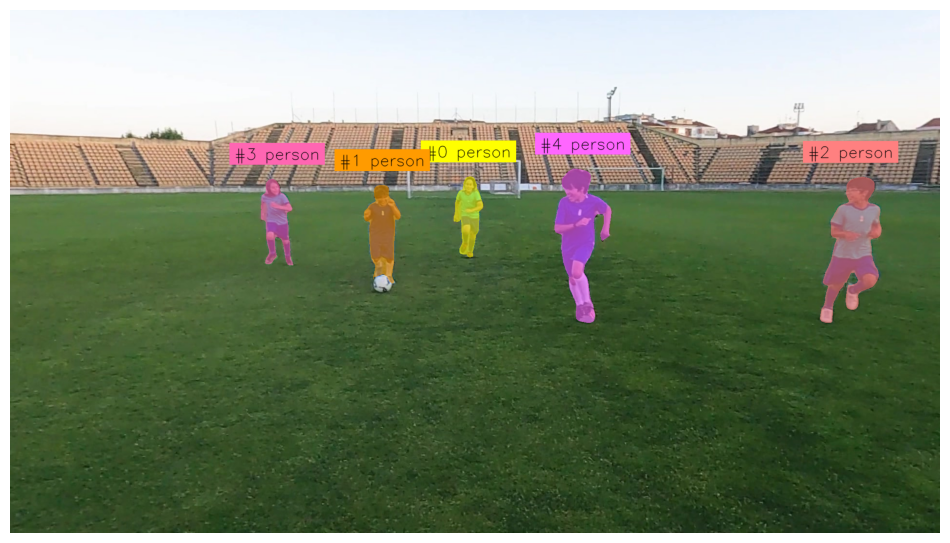

In [17]:
detections = from_sam(result)

annotated_frame = annotate(frame, detections, text)

sv.plot_image(annotated_frame)

In [20]:
RESULT_FRAMES = HOME / "segmented_frames"
RESULT_FRAMES.mkdir(exist_ok=True)
frame_files = sorted(SOURCE_FRAMES.glob("*.jpg"))

In [22]:
RESULT_FRAMES = HOME / "segmented_frames"
RESULT_FRAMES.mkdir(exist_ok=True)
frame_files = sorted(SOURCE_FRAMES.glob("*.jpg"))

for idx, frame_path in tqdm(enumerate(frame_files), total=len(frame_files)):
    frame = load_frame(SOURCE_FRAMES, idx)

    # Start a temporary session for each frame
    response = predictor.handle_request(
        request=dict(
            type="start_session",
            resource_path=str(frame_path),
        )
    )
    temp_session = response["session_id"]

    # Add prompt "person"
    response = predictor.handle_request(
        request=dict(
            type="add_prompt",
            session_id=temp_session,
            frame_index=0,  # only one frame
            text="person",
        )
    )
    frame_out = response["outputs"]

    # Convert + annotate
    detections = from_sam(frame_out)
    annotated = annotate(frame, detections, text="person")

    # Save frame
    cv2.imwrite(str(RESULT_FRAMES / frame_path.name), annotated)

    # Close session + clear GPU
    predictor.handle_request(
        request=dict(
            type="reset_session",
            session_id=temp_session,
        )
    )
    torch.cuda.empty_cache()

100%|██████████| 290/290 [19:42<00:00,  4.08s/it]


In [23]:
!ffmpeg -framerate 30 -i {RESULT_FRAMES}/%05d.jpg -c:v libx264 -pix_fmt yuv420p segmented_output.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [24]:
import cv2
import torch
from tqdm import tqdm
import numpy as np

# Prepare result folder
RESULT_FRAMES = HOME / "segmented_frames"
RESULT_FRAMES.mkdir(exist_ok=True)
frame_files = sorted(SOURCE_FRAMES.glob("*.jpg"))

# Start session on first frame
frame0 = load_frame(SOURCE_FRAMES, 0)
response = predictor.handle_request(
    request=dict(
        type="start_session",
        resource_path=SOURCE_FRAMES.as_posix(),
    )
)
session_id = response["session_id"]

# Add prompt "person" only on first frame
response = predictor.handle_request(
    request=dict(
        type="add_prompt",
        session_id=session_id,
        frame_index=0,
        text="person",
    )
)
frame_out = response["outputs"]
detections0 = from_sam(frame_out)

# Initialize OpenCV MultiTracker
trackers = cv2.legacy.MultiTracker_create()
for xyxy in detections0.xyxy:
    x1, y1, x2, y2 = xyxy
    tracker = cv2.legacy.TrackerCSRT_create()
    trackers.add(tracker, frame0, (x1, y1, x2-x1, y2-y1))

# Annotate first frame and save
annotated0 = annotate(frame0, detections0, text="person")
cv2.imwrite(str(RESULT_FRAMES / frame_files[0].name), annotated0)

# Process remaining frames
for idx, frame_path in tqdm(enumerate(frame_files[1:], start=1), total=len(frame_files)-1):
    frame = load_frame(SOURCE_FRAMES, idx)
    success, boxes = trackers.update(frame)

    # Convert boxes to detections format for annotation
    detections = sv.Detections(
        xyxy=np.array(boxes),
        mask=None,
        confidence=None,
        tracker_id=np.arange(len(boxes))  # maintain IDs
    )
    annotated = annotate(frame, detections, text="person")
    cv2.imwrite(str(RESULT_FRAMES / frame_path.name), annotated)

frame loading (image folder) [rank=0]: 100%|██████████| 290/290 [00:12<00:00, 23.71it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.60 GiB. GPU 0 has a total capacity of 14.74 GiB of which 476.12 MiB is free. Process 24893 has 14.27 GiB memory in use. Of the allocated memory 13.79 GiB is allocated by PyTorch, and 369.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Propagate in video

In [ ]:
def propagate_in_video(predictor, session_id):
    frame_outputs = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
        )
    ):
        frame_outputs[response["frame_index"]] = response["outputs"]

    return frame_outputs

In [ ]:
frame_outputs = propagate_in_video(predictor=predictor, session_id=session_id)

propagate_in_video:   0%|          | 0/429 [00:00<?, ?it/s]

propagate_in_video: 0it [00:00, ?it/s]

In [ ]:
TARGET_VIDEO = HOME / f"{SOURCE_VIDEO.stem}-result{SOURCE_VIDEO.suffix}"
TARGET_VIDEO_COMPRESSED = HOME / f"{TARGET_VIDEO.stem}-compressed{TARGET_VIDEO.suffix}"

def callback(frame: np.ndarray, index: int) -> np.ndarray:
    annotated_frame = frame.copy()
    output = frame_outputs[index]
    detections = from_sam(output)
    return annotate(frame, detections, text)

sv.process_video(
    source_path=SOURCE_VIDEO,
    target_path=TARGET_VIDEO,
    callback=callback
)

!ffmpeg -y -loglevel error -i {TARGET_VIDEO} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED}

In [ ]:
Video(TARGET_VIDEO_COMPRESSED, embed=True, width=1080)

<div align="center">
  <p>
    Looking for more tutorials or have questions?
    Check out our <a href="https://github.com/roboflow/notebooks">GitHub repo</a> for more notebooks,
    or visit our <a href="https://discord.gg/GbfgXGJ8Bk">discord</a>.
  </p>
  
  <p>
    <strong>If you found this helpful, please consider giving us a ⭐
    <a href="https://github.com/roboflow/notebooks">on GitHub</a>!</strong>
  </p>

</div>